# Paper Analysis

This notebook generates the graphs contained within the paper. It should all just run 🤞

(Make sure you've filled out the config file and unzipped the results if you decide to run it.)

## Loading in the Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
from datetime import datetime
import numpy as np
import json

from matplotlib.lines import Line2D
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from mp_sampling import get_ce_mean_and_std, plot_group_similarity_across_runs_simple, plot_group_similarity_across_runs_stepped, get_CE_means_fixed_windows
from analysis_functions import highlight_significant_windows, highlight_significant_changes, get_significant_windows, plot_hlines
from helper_functions import plot_timeline

import sys
sys.path.insert(1, "../../")
from settings import DB_FP

with open("../project-config.json") as config_file:
    project_config = json.load(config_file)
    
results_fp = project_config["CHUNK_RESULTS_DIR_ALL"]
results_fp_eu = project_config["CHUNK_RESULTS_DIR_EU"]
out_fp = os.path.join(project_config["GRAPHS_DIR"], "chunks")

from helper_functions import check_dir

check_dir(out_fp)

kw_dir = project_config["KW_DIR"]

In [2]:
dates_fp = project_config["DATES_FP"]

key_dates = pd.read_csv(dates_fp, delimiter="\t")

convert_to_date = lambda x: datetime.strptime(x, "%d-%m-%Y")
key_dates["date"] = key_dates["date"].apply(convert_to_date)
key_dates.set_index("date", inplace=True)
key_dates = key_dates.sort_index(ascending=True)

In [3]:
def get_CE_comparisons(fp):
    with open(fp) as results_file:
        results = json.load(results_file)

    comparisons = [{gsnap: {gtest: {datetime.strptime(w, "%Y-%m-%d"): pd.Series(run[gsnap][gtest][w]) for w in run[gsnap][gtest]} for gtest in run[gsnap]} for gsnap in run} for run in results["comparisons"]]
    return comparisons

def get_ends_of_windows(fp):
    with open(fp) as results_file:
        results = json.load(results_file)
            
    return [datetime.strptime(w, "%Y-%m-%d") for w in results["end_of_windows"]] 

def plot_significant_changes(curr_runs, curr_end_dates, ax, colour):
    curr_2nd = curr_runs.iloc[1:]
    curr_1st = curr_runs.iloc[:-1].set_index(curr_2nd.index)
    significant_changes = get_significant_windows(curr_2nd, curr_1st, curr_end_dates[1:])
    plot_hlines(significant_changes, ax, colour)

## Do Remainer MPs from Leave Constituencies become more similar to Leavers after the Referendum?

In [4]:
comparisons = get_CE_comparisons(os.path.join(results_fp, "remain_constituency.json"))
end_dates = get_ends_of_windows(os.path.join(results_fp, "remain_constituency.json"))

leaver_r_con_runs = get_CE_means_fixed_windows(comparisons, "Leavers", "Remain_Constituency_Remainers")
leaver_l_con_runs = get_CE_means_fixed_windows(comparisons, "Leavers", "Leave_Constituency_Remainers")

leaver_leaver_runs = get_CE_means_fixed_windows(comparisons, "Leavers", "Leavers")

leaver_r_con_means, leaver_r_con_stds = get_ce_mean_and_std(comparisons, "Leavers", "Remain_Constituency_Remainers")
leaver_l_con_means, leaver_l_con_stds = get_ce_mean_and_std(comparisons, "Leavers", "Leave_Constituency_Remainers")

leaver_leaver_means, leaver_leaver_stds = get_ce_mean_and_std(comparisons, "Leavers", "Leavers")

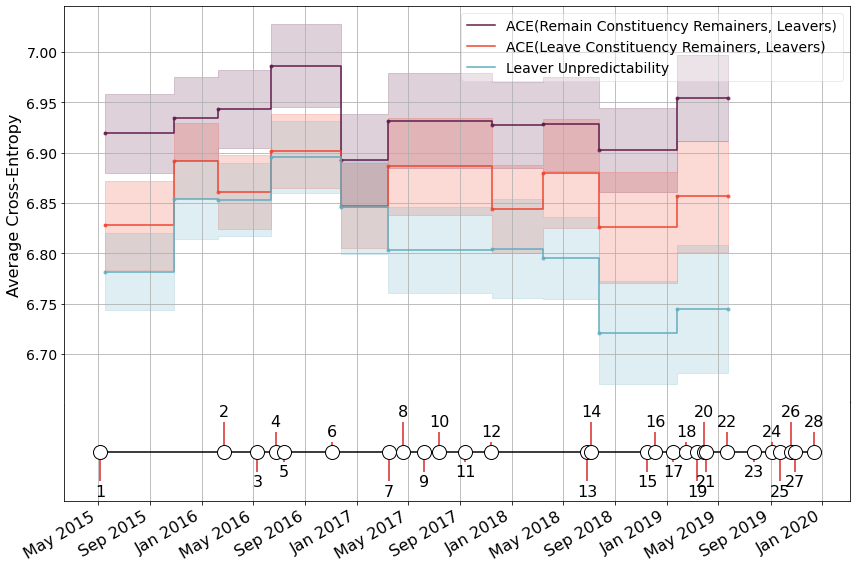

In [5]:
# Comment this back and remove the below chunk if you don't want the timeline
# fig, ax = plt.subplots(figsize=(12, 8))

fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1], hspace=0)
ax = plt.subplot(gs[0])
ax_time = plt.subplot(gs[1], sharex=ax)
fig.subplots_adjust(hspace=0, wspace=0)
colour_list = ["#601A4A", "#EE442F", "#63ACBE"]

plot_group_similarity_across_runs_stepped(leaver_r_con_means, leaver_r_con_stds, ax, colour=colour_list[0], label='ACE(Remain Constituency Remainers, Leavers)', fill_alpha=0.2, end_dates=end_dates)

plot_group_similarity_across_runs_stepped(leaver_l_con_means, leaver_l_con_stds, ax, colour=colour_list[1], label='ACE(Leave Constituency Remainers, Leavers)', fill_alpha=0.2, end_dates=end_dates)

plot_group_similarity_across_runs_stepped(leaver_leaver_means, leaver_leaver_stds, ax, colour=colour_list[2], label='Leaver Unpredictability', fill_alpha=0.2, end_dates=end_dates)

ax.set_ylabel("Average Cross-Entropy", fontsize=16)

ax.grid()

ax.legend(fontsize=14, framealpha=0.4)

# Comment this chunk out if you don't want the timeline
names = np.arange(key_dates.shape[0]) + 1
dates = key_dates.index
plot_timeline(ax_time, dates, names, fontsize=16)
plt.setp(ax.get_xticklabels(), visible=False)
ax_time.spines['left'].set_visible(True)
ax_time.spines['right'].set_visible(True)

ax.tick_params(labelsize=14)

plt.tight_layout()

fig.savefig(os.path.join(out_fp, "remainer_constituency_ce.pdf"))

plt.show()

The above graph suggests that for the most part there isn't much of an increase in divergence from either group.
We can get a slightly better impression if we plot the difference between remainer CE and leaver unpredictability.
Here we are treating the leaver unpredictability as a baseline.

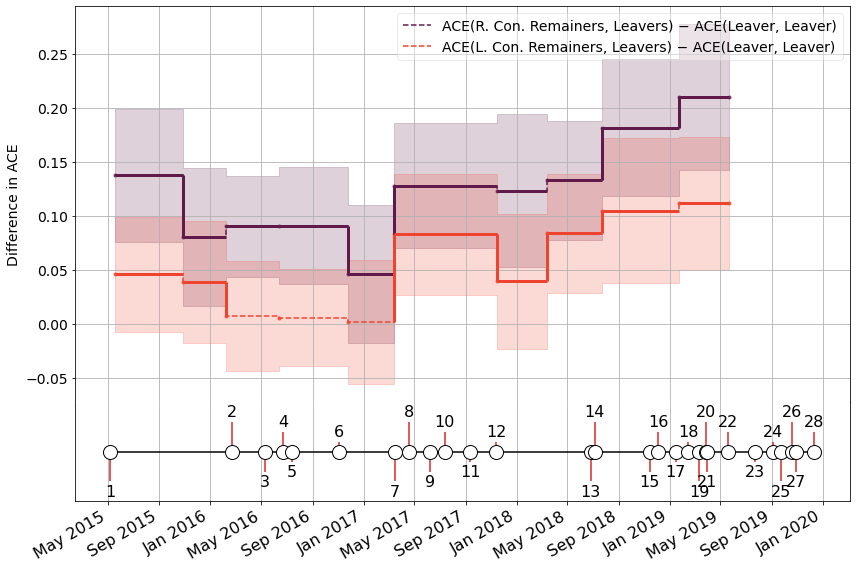

In [6]:
leaver_r_con_diff = leaver_r_con_runs - leaver_leaver_runs
leaver_l_con_diff = leaver_l_con_runs - leaver_leaver_runs

# Comment this back and remove the below chunk if you don't want the timeline
# fig, ax = plt.subplots(figsize=(12, 8))

fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1], hspace=0)
ax = plt.subplot(gs[0])
ax_time = plt.subplot(gs[1], sharex=ax)
fig.subplots_adjust(hspace=0, wspace=0)
colour_list = ["#601A4A", "#EE442F", "#63ACBE"]

colour_list = ["#601A4A", "#EE442F", "#63ACBE"]

means = leaver_r_con_diff.mean(axis=1)
stds = leaver_r_con_diff.std(axis=1)

plot_group_similarity_across_runs_stepped(means, stds, ax, colour=colour_list[0], label="ACE(R. Con. Remainers, Leavers) − ACE(Leaver, Leaver)", line_style="--", line_alpha=1, fill_alpha=0.2, end_dates=end_dates)
highlight_significant_changes(leaver_r_con_diff, end_dates, ax, colour_list[0], line_alpha=0)
h_lines = [[means.loc[x[1]], x[1], x[2]] for x in get_significant_windows(leaver_r_con_runs, leaver_leaver_runs, end_dates, sig_level=0.01)]
plot_hlines(h_lines, ax, colour_list[0])

means = leaver_l_con_diff.mean(axis=1)
stds = leaver_l_con_diff.std(axis=1)

plot_group_similarity_across_runs_stepped(means, stds, ax, colour=colour_list[1], label="ACE(L. Con. Remainers, Leavers) − ACE(Leaver, Leaver)", line_style="--", line_alpha=1, fill_alpha=0.2, end_dates=end_dates)
highlight_significant_changes(leaver_l_con_diff, end_dates, ax, colour_list[1], line_alpha=0)
h_lines = [[means.loc[x[1]], x[1], x[2]] for x in get_significant_windows(leaver_l_con_runs, leaver_leaver_runs, end_dates, sig_level=0.01)]
plot_hlines(h_lines, ax, colour_list[1])


ax.set_ylabel("Difference in ACE", fontsize=14)

ax.grid()
ax.tick_params(labelsize=14)
ax.legend(fontsize=14, framealpha=0.4)

# Comment this chunk out if you don't want the timeline
names = np.arange(key_dates.shape[0]) + 1
dates = key_dates.index
plot_timeline(ax_time, dates, names, fontsize=16)
plt.setp(ax.get_xticklabels(), visible=False)
ax_time.spines['left'].set_visible(True)
ax_time.spines['right'].set_visible(True)

plt.tight_layout()

fig.savefig(os.path.join(out_fp, "Remainer_Constituency_Sub_Leave.pdf"))

plt.show()

Now we can see that remainers from remain constituencies begin to diverge compared to those from leave constituencies towards the end of the time span.

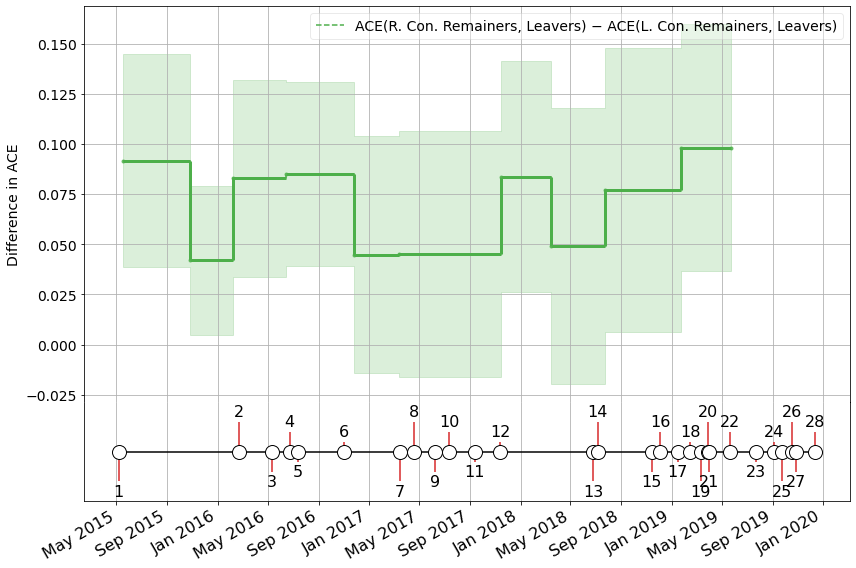

In [7]:
leaver_r_con_diff = leaver_r_con_runs - leaver_l_con_runs

# Comment this back and remove the below chunk if you don't want the timeline
# fig, ax = plt.subplots(figsize=(12, 8))

fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1], hspace=0)
ax = plt.subplot(gs[0])
ax_time = plt.subplot(gs[1], sharex=ax)
fig.subplots_adjust(hspace=0, wspace=0)
colour_list = ["#601A4A", "#EE442F", "#63ACBE"]

colour_list = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3"]

means = leaver_r_con_diff.mean(axis=1)
stds = leaver_r_con_diff.std(axis=1)

plot_group_similarity_across_runs_stepped(means, stds, ax, colour=colour_list[2], label="ACE(R. Con. Remainers, Leavers) − ACE(L. Con. Remainers, Leavers)", line_style="--", line_alpha=1, fill_alpha=0.2, end_dates=end_dates)
highlight_significant_changes(leaver_r_con_diff, end_dates, ax, colour_list[2], line_alpha=0)
h_lines = [[means.loc[x[1]], x[1], x[2]] for x in get_significant_windows(leaver_r_con_runs, leaver_l_con_runs, end_dates, sig_level=0.01)]
plot_hlines(h_lines, ax, colour_list[2])

ax.set_ylabel("Difference in ACE", fontsize=14)

ax.grid()
ax.tick_params(labelsize=14)
ax.legend(fontsize=14, framealpha=0.4)

# Comment this chunk out if you don't want the timeline
names = np.arange(key_dates.shape[0]) + 1
dates = key_dates.index
plot_timeline(ax_time, dates, names, fontsize=16)
plt.setp(ax.get_xticklabels(), visible=False)
ax_time.spines['left'].set_visible(True)
ax_time.spines['right'].set_visible(True)

plt.tight_layout()

fig.savefig(os.path.join(out_fp, "Remainer_Constituency_Differences.pdf"))

plt.show()

In [8]:
leaver_r_con_diff.index[-3]

Timestamp('2018-03-15 00:00:00')

## Are MPs more defined by their party or their Referendum Stance?

In [9]:
party_comparisons = get_CE_comparisons(os.path.join(results_fp, "conservative_labour.json"))
end_dates = get_ends_of_windows(os.path.join(results_fp, "conservative_labour.json"))

con_con_runs = get_CE_means_fixed_windows(party_comparisons, "Conservative", "Conservative")
con_lab_runs = get_CE_means_fixed_windows(party_comparisons, "Conservative", "Labour")

lab_con_runs = get_CE_means_fixed_windows(party_comparisons, "Labour", "Conservative")
lab_lab_runs = get_CE_means_fixed_windows(party_comparisons, "Labour", "Labour")

con_con_means, con_con_stds = get_ce_mean_and_std(party_comparisons, "Conservative", "Conservative")
con_lab_means, con_lab_stds = get_ce_mean_and_std(party_comparisons, "Conservative", "Labour")

lab_con_means, lab_con_stds = get_ce_mean_and_std(party_comparisons, "Labour", "Conservative")
lab_lab_means, lab_lab_stds = get_ce_mean_and_std(party_comparisons, "Labour", "Labour")

In [10]:
ref_comparisons = get_CE_comparisons(os.path.join(results_fp, "remain_leave.json"))
ref_end_dates = get_ends_of_windows(os.path.join(results_fp, "remain_leave.json"))

remain_remain_runs = get_CE_means_fixed_windows(ref_comparisons, "remain", "remain")
remain_leave_runs = get_CE_means_fixed_windows(ref_comparisons, "remain", "leave")

leave_remain_runs = get_CE_means_fixed_windows(ref_comparisons, "leave", "remain")
leave_leave_runs = get_CE_means_fixed_windows(ref_comparisons, "leave", "leave")

remain_remain_means, remain_remain_stds = get_ce_mean_and_std(ref_comparisons, "remain", "remain")
remain_leave_means, remain_leave_stds = get_ce_mean_and_std(ref_comparisons, "remain", "leave")

leave_remain_means, leave_remain_stds = get_ce_mean_and_std(ref_comparisons, "leave", "remain")
leave_leave_means, leave_leave_stds = get_ce_mean_and_std(ref_comparisons, "leave", "leave")

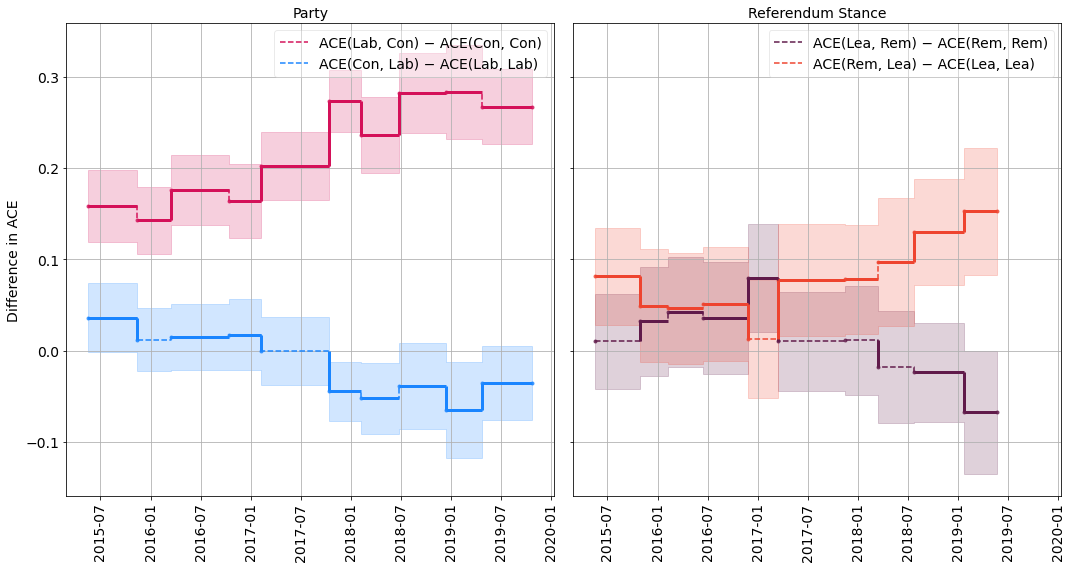

In [11]:
party_end_dates = get_ends_of_windows(os.path.join(results_fp, "conservative_labour.json"))
ref_end_dates = get_ends_of_windows(os.path.join(results_fp, "remain_leave.json"))

con_lab_diff = con_lab_runs - con_con_runs
lab_con_diff = lab_con_runs - lab_lab_runs

remain_leave_diff = remain_leave_runs - remain_remain_runs
leave_remain_diff = leave_remain_runs - leave_leave_runs

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)

colour_list = ["#D41159", "#1A85FF", "#601A4A", "#EE442F"]

means = con_lab_diff.mean(axis=1)
stds = con_lab_diff.std(axis=1)
h_lines = [[means.loc[x[1]], x[1], x[2]] for x in get_significant_windows(con_lab_runs, con_con_runs, party_end_dates, sig_level=0.01)]

plot_group_similarity_across_runs_stepped(means, stds, ax1, colour=colour_list[0], line_style="--", fill_alpha=0.2, label="ACE(Lab, Con) − ACE(Con, Con)", end_dates=party_end_dates, line_alpha=1)
plot_hlines(h_lines, ax1, colour_list[0])
highlight_significant_changes(con_lab_diff, party_end_dates, ax1, colour_list[0], line_alpha=0, sig_level=0.01)

means = lab_con_diff.mean(axis=1)
stds = lab_con_diff.std(axis=1)
h_lines = [[means.loc[x[1]], x[1], x[2]] for x in get_significant_windows(lab_con_runs, lab_lab_runs, party_end_dates, sig_level=0.01)]

plot_group_similarity_across_runs_stepped(means, stds, ax1, colour=colour_list[1], line_style="--", fill_alpha=0.2, label="ACE(Con, Lab) − ACE(Lab, Lab)", end_dates=party_end_dates, line_alpha=1)
plot_hlines(h_lines, ax1, colour_list[1])
highlight_significant_changes(lab_con_diff, party_end_dates, ax1, colour_list[1], line_alpha=0, sig_level=0.01)


ax1.title.set(text='Party', fontsize=14)
ax1.set_ylabel("Difference in ACE", fontsize=14)
ax1.grid()

means = remain_leave_diff.mean(axis=1)
stds = remain_leave_diff.std(axis=1)

plot_group_similarity_across_runs_stepped(means, stds, ax2, colour=colour_list[2], line_style="--", fill_alpha=0.2, label="ACE(Lea, Rem) − ACE(Rem, Rem)", end_dates=ref_end_dates, line_alpha=1)
h_lines = [[means.loc[x[1]], x[1], x[2]] for x in get_significant_windows(remain_leave_runs, remain_remain_runs, ref_end_dates, sig_level=0.01)]
plot_hlines(h_lines, ax2, colour_list[2])
highlight_significant_changes(remain_leave_diff, ref_end_dates, ax2, colour_list[2], line_alpha=0, sig_level=0.01)

means = leave_remain_diff.mean(axis=1)
stds = leave_remain_diff.std(axis=1)

plot_group_similarity_across_runs_stepped(means, stds, ax2, colour=colour_list[3], line_style="--", fill_alpha=0.2, label="ACE(Rem, Lea) − ACE(Lea, Lea)", end_dates=ref_end_dates, line_alpha=1)
h_lines = [[means.loc[x[1]], x[1], x[2]] for x in get_significant_windows(leave_remain_runs, leave_leave_runs, ref_end_dates, sig_level=0.01)]
plot_hlines(h_lines, ax2, colour_list[3])
highlight_significant_changes(leave_remain_diff, ref_end_dates, ax2, colour_list[3], line_alpha=0, sig_level=0.01)

ax2.title.set(text='Referendum Stance', fontsize=14)
ax2.grid()

ax1.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)

ax1.legend(fontsize=14, framealpha=0.4)
ax2.legend(fontsize=14, framealpha=0.4)

plt.tight_layout()

fig.savefig(os.path.join(out_fp, "Identity.pdf"))

plt.show()

The above graph is slightly confusing because it appears that Labour is divergent from the Conservatives but the Conservatives are not divergent from Labour.

This problem emerges because of Labour's high unpredictability.

In [12]:
eu_party_comparisons = get_CE_comparisons(os.path.join(results_fp_eu, "conservative_labour.json"))
eu_party_end_dates = get_ends_of_windows(os.path.join(results_fp_eu, "conservative_labour.json"))

eu_con_con_runs = get_CE_means_fixed_windows(eu_party_comparisons, "Conservative", "Conservative")
eu_con_lab_runs = get_CE_means_fixed_windows(eu_party_comparisons, "Conservative", "Labour")

eu_lab_con_runs = get_CE_means_fixed_windows(eu_party_comparisons, "Labour", "Conservative")
eu_lab_lab_runs = get_CE_means_fixed_windows(eu_party_comparisons, "Labour", "Labour")

eu_con_con_means, eu_con_con_stds = get_ce_mean_and_std(eu_party_comparisons, "Conservative", "Conservative")
eu_con_lab_means, eu_con_lab_stds = get_ce_mean_and_std(eu_party_comparisons, "Conservative", "Labour")

eu_lab_con_means, eu_lab_con_stds = get_ce_mean_and_std(eu_party_comparisons, "Labour", "Conservative")
eu_lab_lab_means, eu_lab_lab_stds = get_ce_mean_and_std(eu_party_comparisons, "Labour", "Labour")

In [13]:
eu_ref_comparisons = get_CE_comparisons(os.path.join(results_fp_eu, "remain_leave.json"))
eu_ref_end_dates = get_ends_of_windows(os.path.join(results_fp_eu, "remain_leave.json"))

eu_remain_remain_runs = get_CE_means_fixed_windows(eu_ref_comparisons, "remain", "remain")
eu_remain_leave_runs = get_CE_means_fixed_windows(eu_ref_comparisons, "remain", "leave")

eu_leave_remain_runs = get_CE_means_fixed_windows(eu_ref_comparisons, "leave", "remain")
eu_leave_leave_runs = get_CE_means_fixed_windows(eu_ref_comparisons, "leave", "leave")

eu_remain_remain_means, eu_remain_remain_stds = get_ce_mean_and_std(eu_ref_comparisons, "remain", "remain")
eu_remain_leave_means, eu_remain_leave_stds = get_ce_mean_and_std(eu_ref_comparisons, "remain", "leave")

eu_leave_remain_means, eu_leave_remain_stds = get_ce_mean_and_std(eu_ref_comparisons, "leave", "remain")
eu_leave_leave_means, eu_leave_leave_stds = get_ce_mean_and_std(eu_ref_comparisons, "leave", "leave")

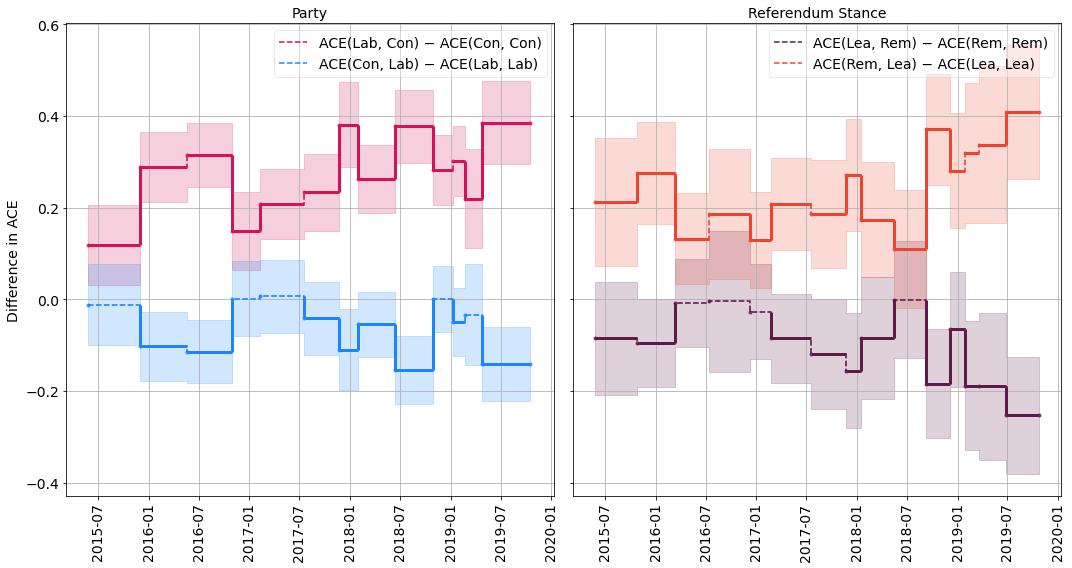

In [14]:
con_lab_diff = eu_con_lab_runs - eu_con_con_runs
lab_con_diff = eu_lab_con_runs - eu_lab_lab_runs

remain_leave_diff = eu_remain_leave_runs - eu_remain_remain_runs
leave_remain_diff = eu_leave_remain_runs - eu_leave_leave_runs

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)

colour_list = ["#D41159", "#1A85FF", "#601A4A", "#EE442F"]

means = con_lab_diff.mean(axis=1)
stds = con_lab_diff.std(axis=1)

plot_group_similarity_across_runs_stepped(means, stds, ax1, colour=colour_list[0], line_style="--", line_alpha=1, fill_alpha=0.2, label="ACE(Lab, Con) − ACE(Con, Con)", end_dates=eu_party_end_dates)
h_lines = [[means.loc[x[1]], x[1], x[2]] for x in get_significant_windows(eu_con_lab_runs, eu_con_con_runs, eu_party_end_dates, sig_level=0.01)]
plot_hlines(h_lines, ax1, colour_list[0])
highlight_significant_changes(con_lab_diff, eu_party_end_dates, ax1, colour_list[0], sig_level=0.01)

means = lab_con_diff.mean(axis=1)
stds = lab_con_diff.std(axis=1)

plot_group_similarity_across_runs_stepped(means, stds, ax1, colour=colour_list[1], line_style="--", line_alpha=1, fill_alpha=0.2, label="ACE(Con, Lab) − ACE(Lab, Lab)", end_dates=eu_party_end_dates)
h_lines = [[means.loc[x[1]], x[1], x[2]] for x in get_significant_windows(eu_lab_con_runs, eu_lab_lab_runs, eu_party_end_dates, sig_level=0.01)]
plot_hlines(h_lines, ax1, colour_list[1])
highlight_significant_changes(lab_con_diff, eu_party_end_dates, ax1, colour_list[1], sig_level=0.01)


ax1.title.set(text='Party', fontsize=14)
ax1.set_ylabel("Difference in ACE", fontsize=14)
ax1.grid()

means = remain_leave_diff.mean(axis=1)
stds = remain_leave_diff.std(axis=1)

plot_group_similarity_across_runs_stepped(means, stds, ax2, colour=colour_list[2], line_style="--", line_alpha=1, fill_alpha=0.2, label="ACE(Lea, Rem) − ACE(Rem, Rem)", end_dates=eu_ref_end_dates)
h_lines = [[means.loc[x[1]], x[1], x[2]] for x in get_significant_windows(eu_remain_leave_runs, eu_remain_remain_runs, eu_ref_end_dates, sig_level=0.01)]
plot_hlines(h_lines, ax2, colour_list[2])
highlight_significant_changes(remain_leave_diff, eu_ref_end_dates, ax2, colour_list[2], sig_level=0.01)


means = leave_remain_diff.mean(axis=1)
stds = leave_remain_diff.std(axis=1)

plot_group_similarity_across_runs_stepped(means, stds, ax2, colour=colour_list[3], line_style="--", line_alpha=2, fill_alpha=0.2, label="ACE(Rem, Lea) − ACE(Lea, Lea)", end_dates=eu_ref_end_dates)
h_lines = [[means.loc[x[1]], x[1], x[2]] for x in get_significant_windows(eu_leave_remain_runs, eu_leave_leave_runs, eu_ref_end_dates, sig_level=0.01)]
plot_hlines(h_lines, ax2, colour_list[3])
highlight_significant_changes(leave_remain_diff, eu_ref_end_dates, ax2, colour_list[3], sig_level=0.01)


ax2.title.set(text='Referendum Stance', fontsize=14)
ax2.grid()

ax1.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)

ax1.legend(fontsize=14, framealpha=0.4)
ax2.legend(fontsize=14, framealpha=0.4)

plt.tight_layout()

fig.savefig(os.path.join(out_fp, "EU_Identity.pdf"))

plt.show()

# How consistent were the groups over time?

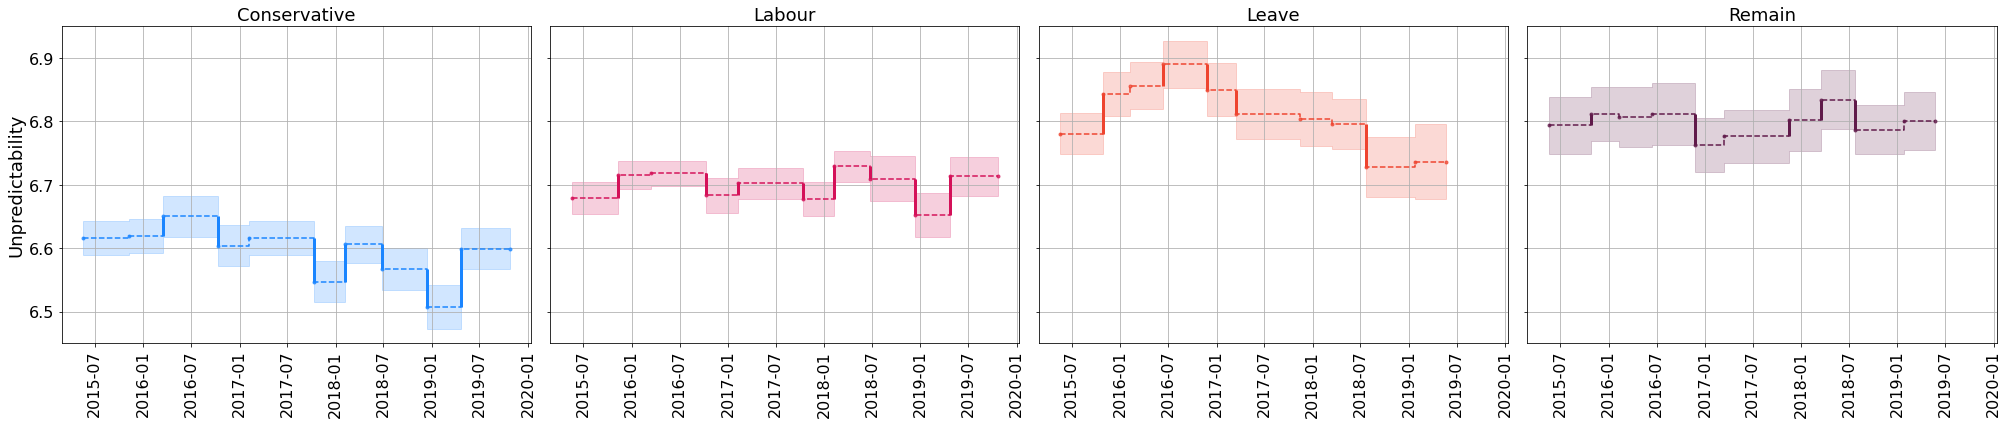

In [15]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(28, 6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)

colour_list = ["#D41159", "#1A85FF", "#601A4A", "#EE442F"]

plot_group_similarity_across_runs_stepped(con_con_means, con_con_stds, ax1, colour=colour_list[1], line_style="--", line_alpha=1, fill_alpha=0.2, end_dates=party_end_dates)
highlight_significant_changes(con_con_runs, party_end_dates, ax1, colour_list[1], line_alpha=0, sig_level=0.01)

plot_group_similarity_across_runs_stepped(lab_lab_means, lab_lab_stds, ax2, colour=colour_list[0], line_style="--", line_alpha=1, fill_alpha=0.2, end_dates=party_end_dates)
highlight_significant_changes(lab_lab_runs, party_end_dates, ax2, colour_list[0], line_alpha=0, sig_level=0.01)

plot_group_similarity_across_runs_stepped(leave_leave_means, leave_leave_stds, ax3, colour=colour_list[3], line_style="--", line_alpha=1, fill_alpha=0.2, end_dates=ref_end_dates)
highlight_significant_changes(leave_leave_runs, ref_end_dates, ax3, colour_list[3], line_alpha=0, sig_level=0.01)

plot_group_similarity_across_runs_stepped(remain_remain_means, remain_remain_stds, ax4, colour=colour_list[2], line_style="--", line_alpha=1, fill_alpha=0.2, end_dates=ref_end_dates)
highlight_significant_changes(remain_remain_runs, ref_end_dates, ax4, colour_list[2], line_alpha=0, sig_level=0.01)

ax1.title.set(text='Conservative', fontsize=18)
ax2.title.set(text='Labour', fontsize=18)

ax3.title.set(text='Leave', fontsize=18)
ax4.title.set(text='Remain', fontsize=18)

ax1.set_ylabel("Unpredictability", fontsize=18)

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()

ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax3.tick_params(labelsize=16)
ax4.tick_params(labelsize=16)

# plt.ylim(6.1, 6.9)
plt.tight_layout()

fig.savefig(os.path.join(out_fp, "all_unpredictability.pdf"))

plt.show()

In [16]:
eu_party_comparisons = get_CE_comparisons(os.path.join(results_fp_eu, "conservative_labour.json"))
eu_party_end_dates = get_ends_of_windows(os.path.join(results_fp_eu, "conservative_labour.json"))

eu_con_con_runs = get_CE_means_fixed_windows(eu_party_comparisons, "Conservative", "Conservative")
eu_lab_lab_runs = get_CE_means_fixed_windows(eu_party_comparisons, "Labour", "Labour")

eu_con_con_means, eu_con_con_stds = get_ce_mean_and_std(eu_party_comparisons, "Conservative", "Conservative")
eu_lab_lab_means, eu_lab_lab_stds = get_ce_mean_and_std(eu_party_comparisons, "Labour", "Labour")

eu_ref_comparisons = get_CE_comparisons(os.path.join(results_fp_eu, "remain_leave.json"))
eu_ref_end_dates = get_ends_of_windows(os.path.join(results_fp_eu, "remain_leave.json"))

eu_remain_remain_runs = get_CE_means_fixed_windows(eu_ref_comparisons, "remain", "remain")
eu_leave_leave_runs = get_CE_means_fixed_windows(eu_ref_comparisons, "leave", "leave")

eu_remain_remain_means, eu_remain_remain_stds = get_ce_mean_and_std(eu_ref_comparisons, "remain", "remain")
eu_leave_leave_means, eu_leave_leave_stds = get_ce_mean_and_std(eu_ref_comparisons, "leave", "leave")

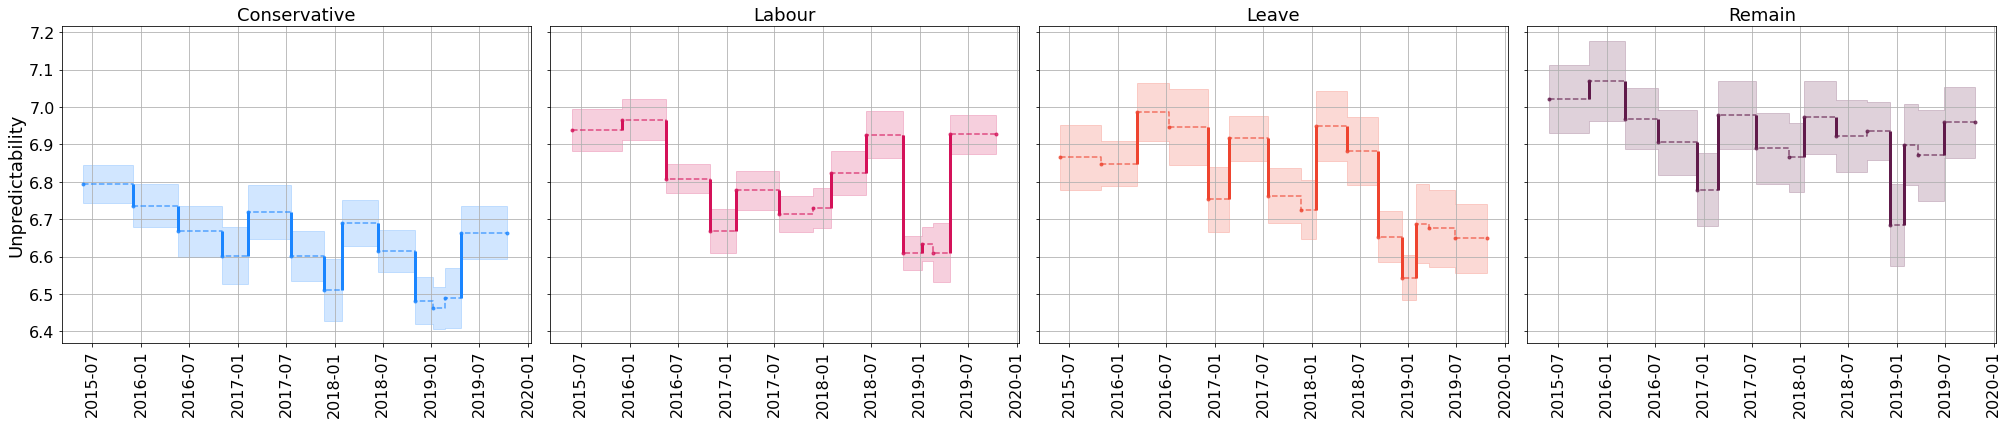

In [17]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(28, 6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)

colour_list = ["#D41159", "#1A85FF", "#601A4A", "#EE442F"]

plot_group_similarity_across_runs_stepped(eu_con_con_means, eu_con_con_stds, ax1, colour=colour_list[1], line_style="--", line_alpha=0.7,fill_alpha=0.2, end_dates=eu_party_end_dates)
highlight_significant_changes(eu_con_con_runs, eu_party_end_dates, ax1, colour_list[1], line_alpha=0, sig_level=0.01)

plot_group_similarity_across_runs_stepped(eu_lab_lab_means, eu_lab_lab_stds, ax2, colour=colour_list[0], line_style="--", line_alpha=0.7,fill_alpha=0.2, end_dates=eu_party_end_dates)
highlight_significant_changes(eu_lab_lab_runs, eu_party_end_dates, ax2, colour_list[0], line_alpha=0, sig_level=0.01)

plot_group_similarity_across_runs_stepped(eu_leave_leave_means, eu_leave_leave_stds, ax3, colour=colour_list[3], line_style="--", line_alpha=0.7, fill_alpha=0.2, end_dates=eu_ref_end_dates)
highlight_significant_changes(eu_leave_leave_runs, eu_ref_end_dates, ax3, colour_list[3], line_alpha=0, sig_level=0.01)

plot_group_similarity_across_runs_stepped(eu_remain_remain_means, eu_remain_remain_stds, ax4, colour=colour_list[2], line_style="--", line_alpha=0.7, fill_alpha=0.2, end_dates=eu_ref_end_dates)
highlight_significant_changes(eu_remain_remain_runs, eu_ref_end_dates, ax4, colour_list[2], line_alpha=0, sig_level=0.01)


ax1.title.set(text='Conservative', fontsize=18)
ax2.title.set(text='Labour', fontsize=18)

ax3.title.set(text='Leave', fontsize=18)
ax4.title.set(text='Remain', fontsize=18)

ax1.set_ylabel("Unpredictability", fontsize=18)

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()

ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax3.tick_params(labelsize=16)
ax4.tick_params(labelsize=16)

# plt.ylim(6.1, 6.9)
plt.tight_layout()

fig.savefig(os.path.join(out_fp, "eu_unpredictability.pdf"))

plt.show()

In [18]:
eu_lab_lab_means.index

DatetimeIndex(['2015-05-27', '2015-12-02', '2016-05-19', '2016-10-31',
               '2017-02-07', '2017-07-19', '2017-11-22', '2018-01-30',
               '2018-06-13', '2018-10-30', '2019-01-09', '2019-02-21',
               '2019-04-24'],
              dtype='datetime64[ns]', freq=None)

# Keywords

In [19]:
def get_kw_diff_and_rank(kw1, kw2, cols):
    # Compare the local window vs ref to the global lab vs global ref.
    shared_kw = pd.concat([kw1, kw2], axis=1).dropna()
    shared_kw.columns = cols

    shared_kw["difference"] = shared_kw[cols[0]] - shared_kw[cols[1]]

    ranks1 = pd.Series(np.arange(1, len(shared_kw)+1), index=shared_kw.loc[:, cols[0]].sort_values(ascending=False).index)
    ranks2 = pd.Series(np.arange(1, len(shared_kw)+1), index=shared_kw.loc[:, cols[1]].sort_values(ascending=False).index)

    shared_kw["{} Rank".format(cols[0])] = ranks1
    shared_kw["{} Rank".format(cols[1])] = ranks2
    shared_kw["Rank Difference"] = -(shared_kw["{} Rank".format(cols[0])] - shared_kw["{} Rank".format(cols[1])])
    return shared_kw

## KW of last three windows compared to before

In [20]:
with open(os.path.join(kw_dir, "rise_kw_before.json")) as curr_file:
    eu_kw = json.load(curr_file)
    
kw_rcon = pd.Series(eu_kw["r_con"])
kw_lcon = pd.Series(eu_kw["l_con"])
kw_leav = pd.Series(eu_kw["leavers"])

In [21]:
print("R-Con: ", ", ".join(kw_rcon.head(10).index))
print("L-Con: ", ", ".join(kw_lcon.head(10).index))
print("Leave: ", ", ".join(kw_leav.head(10).index))

R-Con:  windrush, erg, backstop, prorogue, proroguing, ccps, stockpiling, yellowhammer, antisemitism, fsma
L-Con:  windrush, proserve, echa, stockpiling, erg, cian, maraviroc, ucNUMBER, mtd, guaidó
Leave:  backstop, trailer, ammonium, agrifood, flybmi, cptpp, windrush, seine, comber, lakeside


In [22]:
kw_ranks = get_kw_diff_and_rank(kw_rcon, kw_leav, ["R-Con", "Leaver"])

In [23]:
kw_ranks.head(20)

,R-Con,Leaver,difference,R-Con Rank,Leaver Rank,Rank Difference
windrush,9.968801,7.102784,2.866017,1,3,2
backstop,7.570550,8.149587,-0.579037,2,1,-1
yellowhammer,6.715621,6.804703,-0.089082,3,5,2
cptpp,6.397259,7.213815,-0.816556,4,2,-2
seaborne,6.397259,6.896333,-0.499074,5,4,-1
chequers,6.106169,5.846658,0.259511,6,6,0
prorogation,4.754581,4.348745,0.405836,7,12,5
revocation,4.554316,3.883426,0.670890,8,15,7
no-,4.487902,3.747798,0.740105,9,19,10
rulebook,4.384876,5.297647,-0.912771,10,7,-3


In [24]:
kw_ranks.head(50).sort_values("difference", ascending=False).head(20)

,R-Con,Leaver,difference,R-Con Rank,Leaver Rank,Rank Difference
windrush,9.968801,7.102784,2.866017,1,3,2
organic,3.712761,2.338634,1.374127,18,57,39
plastic,3.572470,2.203671,1.368799,24,66,42
crashing,2.494526,1.146338,1.348189,37,155,118
honda,3.573985,2.347897,1.226088,23,56,33
indicative,3.598932,2.458928,1.140005,22,51,29
eurotunnel,4.364838,3.306925,1.057913,11,28,17
hong,3.227334,2.189741,1.037593,28,67,39
deadlock,3.718723,2.690253,1.028469,17,45,28
kong,3.206724,2.189741,1.016983,29,68,39


In [25]:
kw_ranks.head(20).sort_values("Rank Difference", ascending=False).head(20)

,R-Con,Leaver,difference,R-Con Rank,Leaver Rank,Rank Difference
organic,3.712761,2.338634,1.374127,18,57,39
deadlock,3.718723,2.690253,1.028469,17,45,28
eurotunnel,4.364838,3.306925,1.057913,11,28,17
revoke,4.044470,3.352013,0.692457,13,27,14
revoking,4.188860,3.420454,0.768406,12,24,12
duchy,3.808564,3.407703,0.400861,15,25,10
no-,4.487902,3.747798,0.740105,9,19,10
revocation,4.554316,3.883426,0.670890,8,15,7
prorogation,4.754581,4.348745,0.405836,7,12,5
windrush,9.968801,7.102784,2.866017,1,3,2


In [26]:
kw_ranks = get_kw_diff_and_rank(kw_rcon, kw_lcon, ["R-Con", "L-Con"])
kw_ranks.head(20).sort_values("Rank Difference", ascending=False).head(20)

,R-Con,L-Con,difference,R-Con Rank,L-Con Rank,Rank Difference
revocation,4.554316,3.600284,0.954032,18,29,11
rulebook,4.384876,3.651814,0.733061,20,26,6
prorogation,4.754581,4.208208,0.546374,16,20,4
mediation,5.988147,5.005451,0.982695,11,14,3
backstop,7.570550,6.813048,0.757502,3,6,3
proroguing,7.314797,6.590414,0.724383,5,7,2
yellowhammer,6.715621,6.154315,0.561306,7,9,2
chequers,6.106169,5.767291,0.338877,10,12,2
prorogued,4.992869,4.954377,0.038492,14,15,1
prorogue,7.475262,7.196135,0.279127,4,5,1


## EU KW of last three windows (R-con and L-con Remainers)

In [27]:
with open(os.path.join(kw_dir, "rise_kw_eu.json")) as curr_file:
    eu_kw = json.load(curr_file)
    
kw_rcon = pd.Series(eu_kw["r_con"])
kw_lcon = pd.Series(eu_kw["l_con"])
kw_leav = pd.Series(eu_kw["leavers"])

In [28]:
print("R-Con: ", ", ".join(kw_rcon.head(10).index))
print("L-Con: ", ", ".join(kw_lcon.head(10).index))
print("Leave: ", ", ".join(kw_leav.head(10).index))

R-Con:  eu, brexit, brexiteers, eu-, remainers, brexiteer, brexit-, euro, radioisotopes, remainer
L-Con:  eu, brexit, brexiteers, eu-, remainers, euro, remainer, echa, brexiteer, efta
Leave:  eu, brexit, euro, remainers, eu-, brexiteer, brexiteers, ammonium, brexit-, derogations


In [29]:
kw_ranks = get_kw_diff_and_rank(kw_rcon, kw_leav, ["R-Con", "Leaver"])

In [30]:
kw_ranks.head(20)

,R-Con,Leaver,difference,R-Con Rank,Leaver Rank,Rank Difference
eu,15.964668,16.445653,-0.480985,1,1,0
brexit,15.840017,15.163023,0.676994,2,2,0
brexiteers,11.053234,8.616317,2.436917,3,7,4
eu-,9.876837,9.236045,0.640792,4,5,1
remainers,8.885152,9.487584,-0.602431,5,4,-1
brexiteer,8.817248,9.189502,-0.372254,6,6,0
brexit-,8.464577,8.544167,-0.079591,7,8,1
euro,8.223568,9.766560,-1.542991,8,3,-5
remainer,7.799761,8.013652,-0.213892,9,9,0
schengen,7.396405,7.782327,-0.385922,10,11,1


In [31]:
kw_ranks.head(50).sort_values("Rank Difference", ascending=False).head(20)

,R-Con,Leaver,difference,R-Con Rank,Leaver Rank,Rank Difference
organic,3.947001,2.572873,1.374127,50,202,152
deadlock,3.997727,2.969258,1.028469,48,154,106
renegotiate,4.163055,3.258765,0.904290,41,122,81
revoking,4.107342,3.338935,0.768406,45,116,71
no-,4.357079,3.616974,0.740105,36,91,55
negotiated,4.162457,3.502838,0.659619,42,97,55
revocation,4.392627,3.721737,0.670890,33,82,49
revoke,4.517806,3.825349,0.692457,29,75,46
eea,5.218114,4.070003,1.148111,19,60,41
frictionless,4.799326,4.016947,0.782379,25,61,36


In [32]:
kw_ranks = get_kw_diff_and_rank(kw_rcon, kw_lcon, ["R-Con", "L-Con"])
kw_ranks.head(20).sort_values("Rank Difference", ascending=False).head(20)

,R-Con,L-Con,difference,R-Con Rank,L-Con Rank,Rank Difference
backstop,5.574216,4.816714,0.757502,19,32,13
erg,5.872197,5.369189,0.503008,14,23,9
ecj,5.700943,5.188617,0.512326,18,26,8
juncker,5.901640,5.613923,0.287718,13,18,5
brexit-,8.464577,7.820885,0.643692,7,10,3
blindfold,6.739889,6.639278,0.100611,12,14,2
withdrawal,5.835637,5.645755,0.189883,15,17,2
brexiteer,8.817248,8.358542,0.458706,6,8,2
exiting,7.086065,7.545627,-0.459562,11,12,1
schengen,7.396405,7.621576,-0.225171,10,11,1


In [33]:
kw_ranks.head(20).sort_values("difference", ascending=False).head(20)

,R-Con,L-Con,difference,R-Con Rank,L-Con Rank,Rank Difference
brexiteers,11.053234,10.085857,0.967376,3,3,0
backstop,5.574216,4.816714,0.757502,19,32,13
brexit-,8.464577,7.820885,0.643692,7,10,3
ecj,5.700943,5.188617,0.512326,18,26,8
erg,5.872197,5.369189,0.503008,14,23,9
brexiteer,8.817248,8.358542,0.458706,6,8,2
brexit,15.840017,15.538451,0.301566,2,2,0
juncker,5.901640,5.613923,0.287718,13,18,5
eu-,9.876837,9.634873,0.241964,4,4,0
withdrawal,5.835637,5.645755,0.189883,15,17,2


## KW of last three windows (R-con and L-con Remainers) vs Leavers

In [34]:
with open(os.path.join(kw_dir, "rise_kw_leavers.json")) as curr_file:
    eu_kw = json.load(curr_file)
    
kw_rcon = pd.Series(eu_kw["r_con"])
kw_lcon = pd.Series(eu_kw["l_con"])

In [35]:
print("R-Con: ", ", ".join(kw_rcon.head(10).index))
print("L-Con: ", ", ".join(kw_lcon.head(10).index))

R-Con:  highlands, inverness, tory, tories, valproate, pfi, convergence, greens, crofters, chaotic
L-Con:  expectancy, maduro, teesside, proserve, cummings, lung, echa, europa, cian, fake


In [36]:
kw_ranks = get_kw_diff_and_rank(kw_rcon, kw_lcon, ["R-Con", "L-Con"])
kw_ranks.head(20).sort_values("Rank Difference", ascending=False).head(20)

,R-Con,L-Con,difference,R-Con Rank,L-Con Rank,Rank Difference
hostile,4.227838,2.270889,1.956949,12,136,124
tories,4.929398,3.037912,1.891487,3,44,41
tory,5.074691,3.908478,1.166213,2,29,27
homelessness,4.074215,3.308364,0.765851,13,40,27
regulators,4.312727,4.000241,0.312486,11,27,16
chaotic,4.836886,4.212786,0.624100,5,20,15
inverness,5.291968,4.362811,0.929157,1,12,11
badenoch,4.392897,4.251780,0.141117,9,19,10
convergence,4.911364,4.465905,0.445459,4,11,7
strathspey,4.041425,4.131486,-0.090061,15,22,7


## EU KW of Lab/Con 2019 Dip

In [37]:
with open(os.path.join(kw_dir, "dip_eu_kw.json")) as curr_file:
    kw = json.load(curr_file)

In [39]:
lab_kw = pd.Series(kw["lab"])
con_kw = pd.Series(kw["con"])

In [40]:
print("Con: ", ", ".join(con_kw.head(10).index))
print("Lab: ", ", ".join(lab_kw.head(10).index))

Con:  eu, brexit, remainers, brexiteers, exiting, brexiteer, eu-, euro, fertilisers, remainer
Lab:  brexit, eu, brexiteers, blindfold, remainers, eu-, exiting, renegotiation, fertilisers, brexit-


In [41]:
lab_kw.head(20)

brexit           14.202862
eu               14.198286
brexiteers        8.750916
blindfold         8.242452
remainers         7.874065
eu-               7.820625
exiting           7.605774
renegotiation     7.378107
fertilisers       7.302158
brexit-           7.302158
euro              6.950686
schengen          6.847592
remainer          6.736561
brexiteer         6.616267
brinkmanship      6.616267
viii              6.289102
juncker           5.865294
ecj               5.865294
chequers          5.824509
confirmatory      5.793145
dtype: float64

In [42]:
con_kw.head(20)

eu             14.654154
brexit         13.629860
remainers       7.966210
brexiteers      7.936153
exiting         7.936153
brexiteer       7.670078
eu-             7.633084
euro            7.556122
fertilisers     7.474822
remainer        7.199187
echa            7.147657
efta            6.814758
nitrate         6.651700
ammonium        6.651700
withdrawal      6.631923
brexit-         6.575751
ccps            6.495580
eurozone        6.410691
juncker         6.381248
ecj             6.320494
dtype: float64

In [43]:
kw_ranks = get_kw_diff_and_rank(con_kw, lab_kw, ["Conservative", "Labour"])

In [44]:
kw_ranks.head(20)

,Conservative,Labour,difference,Conservative Rank,Labour Rank,Rank Difference
eu,14.654154,14.198286,0.455868,1,2,1
brexit,13.629860,14.202862,-0.573002,2,1,-1
remainers,7.966210,7.874065,0.092146,3,4,1
brexiteers,7.936153,8.750916,-0.814763,4,3,-1
exiting,7.936153,7.605774,0.330379,5,6,1
brexiteer,7.670078,6.616267,1.053811,6,11,5
eu-,7.633084,7.820625,-0.187541,7,5,-2
euro,7.556122,6.950686,0.605436,8,9,1
fertilisers,7.474822,7.302158,0.172664,9,7,-2
remainer,7.199187,6.736561,0.462626,10,10,0


In [45]:
kw_ranks.head(50).sort_values("difference", ascending=False).head(20)

,Conservative,Labour,difference,Conservative Rank,Labour Rank,Rank Difference
orderly,4.369973,1.121851,3.248122,41,416,375
organic,4.713463,2.959438,1.754024,31,127,96
wto,4.280801,2.654584,1.626217,45,156,111
unilateral,4.815198,3.331492,1.483707,26,99,73
efta,6.814758,5.365723,1.449035,11,21,10
exit,4.950156,3.746585,1.203571,24,68,44
ratification,4.349809,3.156835,1.192974,42,113,71
ratify,4.784799,3.601718,1.183080,28,79,51
negotiated,4.731803,3.612079,1.119724,30,77,47
brexiteer,7.670078,6.616267,1.053811,6,11,5


In [46]:
kw_ranks.head(50).sort_values("Rank Difference", ascending=False).head(20)

,Conservative,Labour,difference,Conservative Rank,Labour Rank,Rank Difference
orderly,4.369973,1.121851,3.248122,41,416,375
wto,4.280801,2.654584,1.626217,45,156,111
organic,4.713463,2.959438,1.754024,31,127,96
unilateral,4.815198,3.331492,1.483707,26,99,73
ratification,4.349809,3.156835,1.192974,42,113,71
ratify,4.784799,3.601718,1.183080,28,79,51
negotiated,4.731803,3.612079,1.119724,30,77,47
exit,4.950156,3.746585,1.203571,24,68,44
agreement,4.262077,3.449982,0.812095,47,90,43
referendum,5.021170,4.091448,0.929723,22,52,30


In [47]:
kw_ranks.head(50).sort_values("Rank Difference", ascending=True).head(20)

,Conservative,Labour,difference,Conservative Rank,Labour Rank,Rank Difference
triggering,4.340302,5.435097,-1.094795,43,20,-23
chemicals,4.511348,5.490297,-0.978950,38,19,-19
securitisation,4.659079,5.701514,-1.042435,33,17,-16
norway-,4.598958,5.197041,-0.598083,37,24,-13
erasmus,4.639316,5.031304,-0.391988,36,26,-10
viii,5.066737,6.289102,-1.222365,20,12,-8
ehic,4.253823,4.525664,-0.271842,49,41,-8
sis,4.262462,4.595205,-0.332744,46,39,-7
chequers,5.034676,5.824509,-0.789833,21,15,-6
frictionless,4.810216,5.353970,-0.543754,27,22,-5


In [48]:
kw_ranks.head(50).sort_values("difference", ascending=True).head(20)

,Conservative,Labour,difference,Conservative Rank,Labour Rank,Rank Difference
viii,5.066737,6.289102,-1.222365,20,12,-8
triggering,4.340302,5.435097,-1.094795,43,20,-23
securitisation,4.659079,5.701514,-1.042435,33,17,-16
chemicals,4.511348,5.490297,-0.978950,38,19,-19
brexiteers,7.936153,8.750916,-0.814763,4,3,-1
chequers,5.034676,5.824509,-0.789833,21,15,-6
brexit-,6.575751,7.302158,-0.726407,13,8,-5
norway-,4.598958,5.197041,-0.598083,37,24,-13
brexit,13.629860,14.202862,-0.573002,2,1,-1
frictionless,4.810216,5.353970,-0.543754,27,22,-5


## KW of Lab/Con 2019 Dip vs Before

In [49]:
with open(os.path.join(kw_dir, "dip_bef_kw.json")) as curr_file:
    eu_kw = json.load(curr_file)
    
con_kw = pd.Series(eu_kw["con"])
lab_kw = pd.Series(eu_kw["lab"])

In [50]:
print("Con: ", ", ".join(con_kw.head(10).index))
print("Lab: ", ", ".join(lab_kw.head(10).index))

Con:  proserve, echa, mtd, ammonium, ccps, guaidó, magnus, lima, fsma, flybmi
Lab:  seaborne, fridges, blindfold, confirmatory, le-, ehic, brinkmanship, extras, eurotunnel, indicative


In [51]:
lab_kw.head(20)

seaborne          7.547427
fridges           6.618980
blindfold         6.229568
confirmatory      5.850650
le-               5.571674
ehic              5.197279
brinkmanship      4.965953
extras            4.957566
eurotunnel        4.834709
indicative        4.820702
securitisation    4.788166
unicorns          4.678590
blackmail         4.674244
antisocial        4.638789
stockpiling       4.588548
stabbed           4.545202
deadlock          4.445297
revocation        4.398610
fertilisers       4.371737
botched           4.338751
dtype: float64

In [52]:
con_kw.head(50)

proserve          8.454076
echa              8.304698
mtd               8.015192
ammonium          7.808741
ccps              7.652622
guaidó           7.567733
magnus            7.567733
lima              7.477535
fsma              7.381320
flybmi            7.278226
airlock           7.278226
organics          7.278226
v-                7.278226
mediations        7.167195
maduro            7.167195
bidwells          7.046901
seaborne          6.821019
seahorses         6.771266
geo-              6.771266
nitrate           6.223778
mediation         6.132148
interpretative    5.865731
antisemitism      5.693264
europa            5.693264
selmayr           5.461938
baccalaureate     5.388409
juan              5.155607
venezuela         5.145776
fsa               5.081334
backstop          5.039467
ehic              4.925437
woodlands         4.724973
revoking          4.700877
skills-           4.655789
fertiliser        4.638816
revocation        4.629133
cptpp             4.573965
f

In [53]:
kw_ranks = get_kw_diff_and_rank(con_kw, lab_kw, ["Conservative", "Labour"])

In [54]:
kw_ranks.head(20)

,Conservative,Labour,difference,Conservative Rank,Labour Rank,Rank Difference
seaborne,6.821019,7.547427,-0.726407,1,1,0
venezuela,5.145776,4.131102,1.014674,2,14,12
backstop,5.039467,4.026226,1.013242,3,15,12
ehic,4.925437,5.197279,-0.271842,4,3,-1
revoking,4.700877,4.214981,0.485896,5,12,7
revocation,4.629133,4.398610,0.230524,6,9,3
fertilisers,4.544400,4.371737,0.172664,7,10,3
brady,4.449338,3.963442,0.485896,8,17,9
organic,4.403378,2.649354,1.754024,9,44,35
revoke,4.293516,3.880101,0.413415,10,19,9


In [55]:
kw_ranks.head(50).sort_values("Rank Difference", ascending=False).head(20)

,Conservative,Labour,difference,Conservative Rank,Labour Rank,Rank Difference
temporary,2.254152,1.000966,1.253186,45,147,102
negotiated,2.233493,1.113769,1.119724,48,136,88
withdrawal,2.575376,1.594274,0.981102,37,104,67
amendable,3.149721,1.772699,1.377022,24,90,66
endeavours,3.265402,1.787119,1.478283,22,87,65
packaging,2.462585,1.694228,0.768357,39,96,57
disclosure,2.419316,1.689658,0.729657,41,97,56
conditional,2.735883,1.796028,0.939855,35,85,50
instrument,2.763615,1.905060,0.858555,34,76,42
protocol,2.853909,2.014917,0.838993,31,67,36


In [56]:
kw_ranks.head(50).sort_values("difference", ascending=False).head(20)

,Conservative,Labour,difference,Conservative Rank,Labour Rank,Rank Difference
organic,4.403378,2.649354,1.754024,9,44,35
endeavours,3.265402,1.787119,1.478283,22,87,65
amendable,3.149721,1.772699,1.377022,24,90,66
temporary,2.254152,1.000966,1.253186,45,147,102
negotiated,2.233493,1.113769,1.119724,48,136,88
venezuela,5.145776,4.131102,1.014674,2,14,12
backstop,5.039467,4.026226,1.013242,3,15,12
withdrawal,2.575376,1.594274,0.981102,37,104,67
conditional,2.735883,1.796028,0.939855,35,85,50
instrument,2.763615,1.905060,0.858555,34,76,42


In [57]:
kw_ranks.head(50).sort_values("Rank Difference", ascending=True).head(20)

,Conservative,Labour,difference,Conservative Rank,Labour Rank,Rank Difference
deadlock,2.324030,4.445297,-2.121267,44,8,-36
stockpiling,3.079732,4.588548,-1.508816,25,7,-18
indefinite,2.233832,3.096123,-0.862291,47,31,-16
confirmatory,3.570644,5.850650,-2.280006,18,2,-16
eurotunnel,3.488573,4.834709,-1.346135,19,4,-15
indicative,3.633983,4.820702,-1.186719,17,5,-12
honda,2.994230,3.924651,-0.930421,27,18,-9
meriden,2.905209,3.697205,-0.791996,29,21,-8
securitisation,3.745731,4.788166,-1.042435,14,6,-8
spelman,2.836497,3.414806,-0.578309,33,26,-7


In [58]:
kw_ranks.head(50).sort_values("difference", ascending=True).head(20)

,Conservative,Labour,difference,Conservative Rank,Labour Rank,Rank Difference
confirmatory,3.570644,5.850650,-2.280006,18,2,-16
deadlock,2.324030,4.445297,-2.121267,44,8,-36
stockpiling,3.079732,4.588548,-1.508816,25,7,-18
eurotunnel,3.488573,4.834709,-1.346135,19,4,-15
indicative,3.633983,4.820702,-1.186719,17,5,-12
securitisation,3.745731,4.788166,-1.042435,14,6,-8
honda,2.994230,3.924651,-0.930421,27,18,-9
indefinite,2.233832,3.096123,-0.862291,47,31,-16
meriden,2.905209,3.697205,-0.791996,29,21,-8
seaborne,6.821019,7.547427,-0.726407,1,1,0
